In [1]:
import os
import wave
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal, stats


In [37]:
# Set the path to the data directory
data_dir = 'data'

# Get a list of all WAV files in the data directory
wav_files = [f for f in os.listdir(data_dir) if f.endswith('.wav')]

# Print the total number of WAV files
print(f"Total number of WAV files: {len(wav_files)}")

Total number of WAV files: 743


In [38]:
from collections import Counter

# Calculate the mode manually to avoid issues with scipy.stats.mode
def calculate_mode(data):
    if not data.size:
        return 'No data available'
    data_counter = Counter(data)
    max_count = max(data_counter.values())
    most_common = [num for num, count in data_counter.items() if count == max_count]
    return most_common[0] if most_common else 'No mode found'

# Collect all amplitude values
amplitude_values = []
for file in wav_files:
    with wave.open(os.path.join(data_dir, file), 'rb') as wav:
        data = np.frombuffer(wav.readframes(wav.getnframes()), dtype=np.int16)
        amplitude_values.extend(data)

amplitude_values = np.array(amplitude_values)
mean_amplitude = np.mean(amplitude_values)
median_amplitude = np.median(amplitude_values)
mode_amplitude = calculate_mode(amplitude_values)
std_deviation = np.std(amplitude_values)
skewness = stats.skew(amplitude_values)
kurtosis = stats.kurtosis(amplitude_values)

print("Global Amplitude Statistics:")
print(f"Mean: {mean_amplitude}, Median: {median_amplitude}, Mode: {mode_amplitude}")
print(f"Standard Deviation: {std_deviation}")
print(f"Skewness: {skewness}, Kurtosis: {kurtosis}")




Global Amplitude Statistics:
Mean: 975.1664476018635, Median: 992.0, Mode: 1504
Standard Deviation: 3154.619387966767
Skewness: -0.009132604033709467, Kurtosis: 59.332425608861676


**Global Amplitude Statistics**

The global amplitude statistics for the WAV files are as follows:

- Mean: 975.1664476018635
- Median: 992.0
- Mode: 1504
- Standard Deviation: 3154.619387966767
- Skewness: -0.009132604033709467
- Kurtosis: 59.332425608861676

**Mean, Median, and Mode**
The mean amplitude is slightly lower than the median, suggesting a distribution with a negative skew, although the skewness value is near zero. However, the very high kurtosis value indicates a leptokurtic distribution, meaning that data points are heavily clustered around the mean with frequent outliers (extreme values), as indicated by a mode significantly different from the mean and median.

**Standard Deviation and Skewness**
The large standard deviation relative to the mean and median amplitude indicates wide variability in signal amplitude across all files. The skewness being close to zero suggests the bulk of data is symmetric around the mean, but the kurtosis and mode suggest significant outliers.

**Implications**
High variability and frequent outliers indicate that any compression algorithm needs robust handling of extremes to avoid data loss. Techniques such as outlier-resistant smoothing or transformations might be necessary before compression.


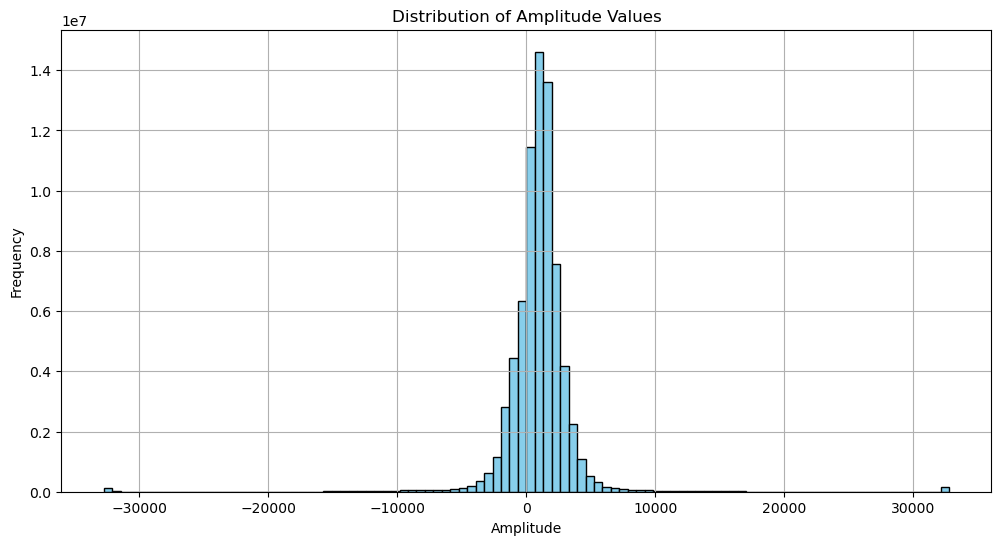

In [49]:
# Plot the distribution of amplitude values
plt.figure(figsize=(12, 6))
plt.hist(amplitude_values, bins=100, color='skyblue', edgecolor='black')
plt.title('Distribution of Amplitude Values')
plt.xlabel('Amplitude')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

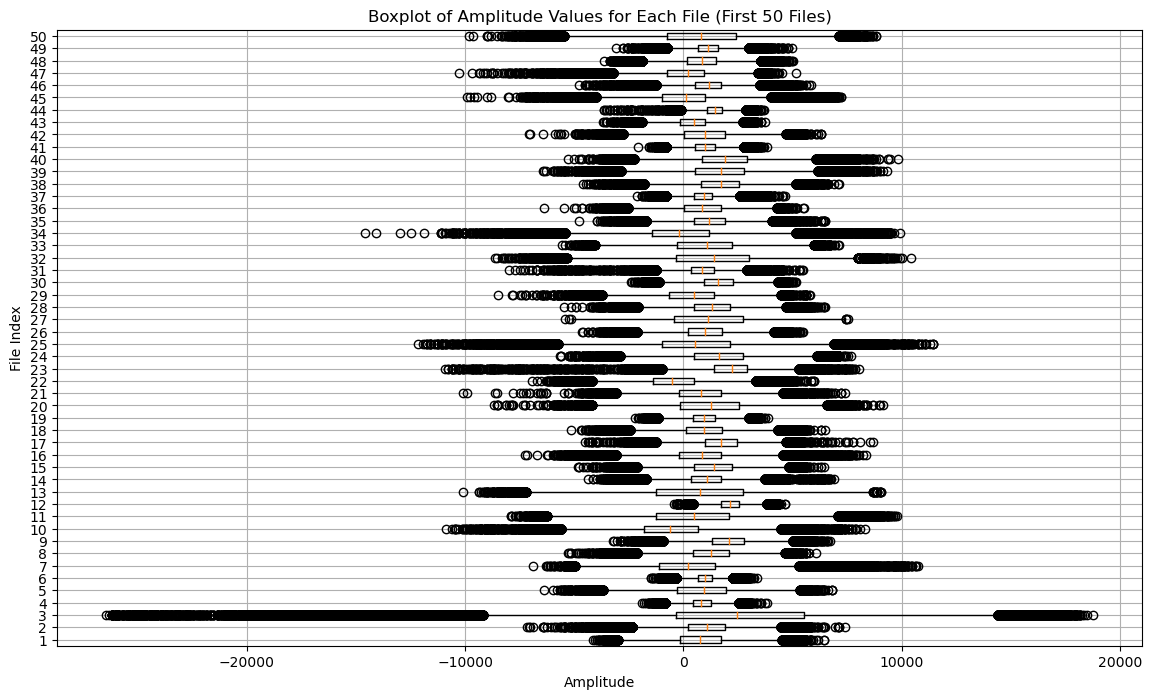

In [50]:
# Boxplot of amplitude values for each file
plt.figure(figsize=(14, 8))
plt.boxplot([np.frombuffer(wave.open(os.path.join(data_dir, file), 'rb').readframes(-1), dtype=np.int16) for file in wav_files[:50]], vert=False)
plt.title('Boxplot of Amplitude Values for Each File (First 50 Files)')
plt.xlabel('Amplitude')
plt.ylabel('File Index')
plt.grid(True)
plt.show()

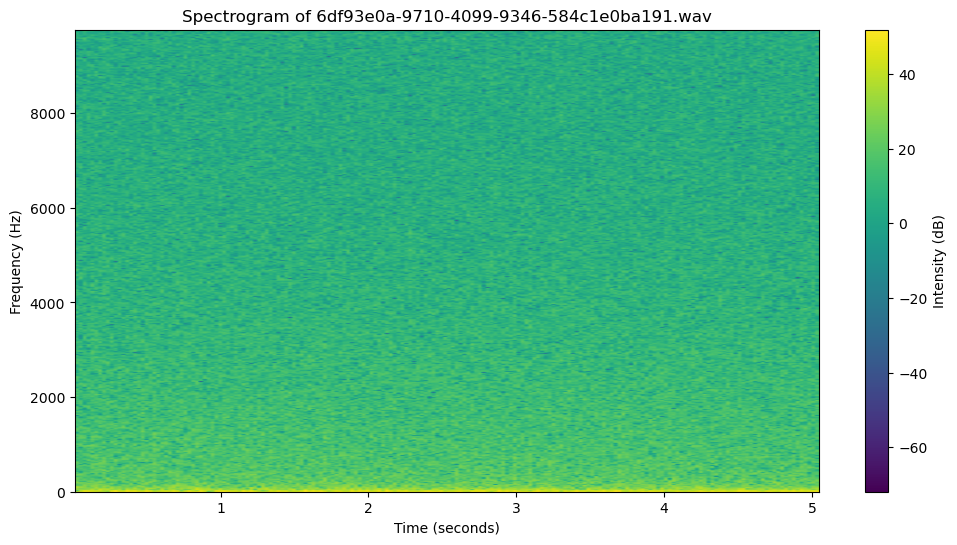

In [51]:
# Plot the spectrogram of a random WAV file
random_wav_file = np.random.choice(wav_files)
with wave.open(os.path.join(data_dir, random_wav_file), 'rb') as wav:
    sample_rate = wav.getframerate()
    wav_data = np.frombuffer(wav.readframes(wav.getnframes()), dtype=np.int16)

plt.figure(figsize=(12, 6))
plt.specgram(wav_data, Fs=sample_rate, NFFT=1024, noverlap=512, cmap='viridis')
plt.title(f'Spectrogram of {random_wav_file}')
plt.xlabel('Time (seconds)')
plt.ylabel('Frequency (Hz)')
plt.colorbar(label='Intensity (dB)')
plt.show()

In [32]:
!pip install seaborn

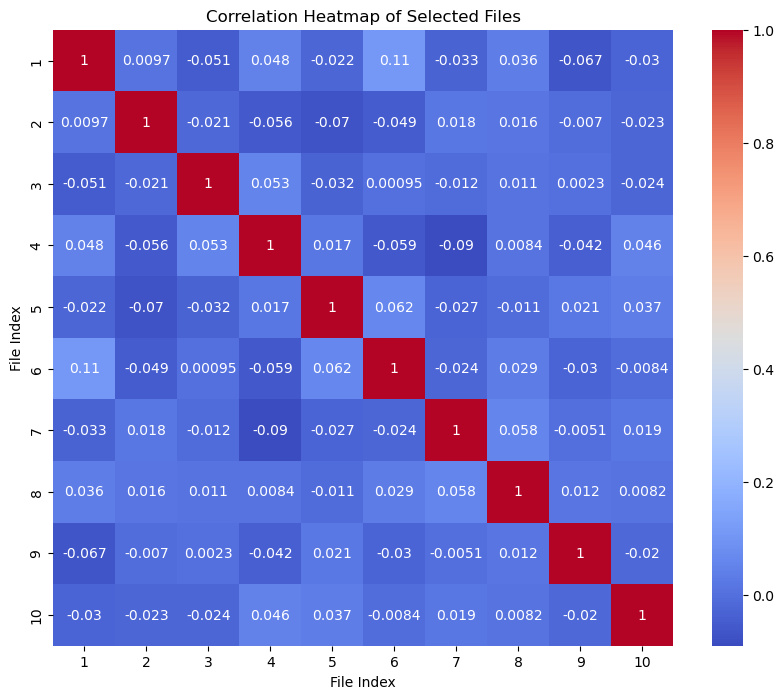

In [33]:
import seaborn as sns

# Correlation heatmap of selected files
selected_files = np.random.choice(wav_files, size=10, replace=False)
min_length = min([wave.open(os.path.join(data_dir, f), 'rb').getnframes() for f in selected_files])

correlation_matrix = np.zeros((10, 10))
for i, file1 in enumerate(selected_files):
    for j, file2 in enumerate(selected_files):
        with wave.open(os.path.join(data_dir, file1), 'rb') as wav1, wave.open(os.path.join(data_dir, file2), 'rb') as wav2:
            data1 = np.frombuffer(wav1.readframes(min_length), dtype=np.int16)
            data2 = np.frombuffer(wav2.readframes(min_length), dtype=np.int16)
            correlation_matrix[i, j] = np.corrcoef(data1, data2)[0, 1]

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', xticklabels=range(1, 11), yticklabels=range(1, 11))
plt.title('Correlation Heatmap of Selected Files')
plt.xlabel('File Index')
plt.ylabel('File Index')
plt.show()

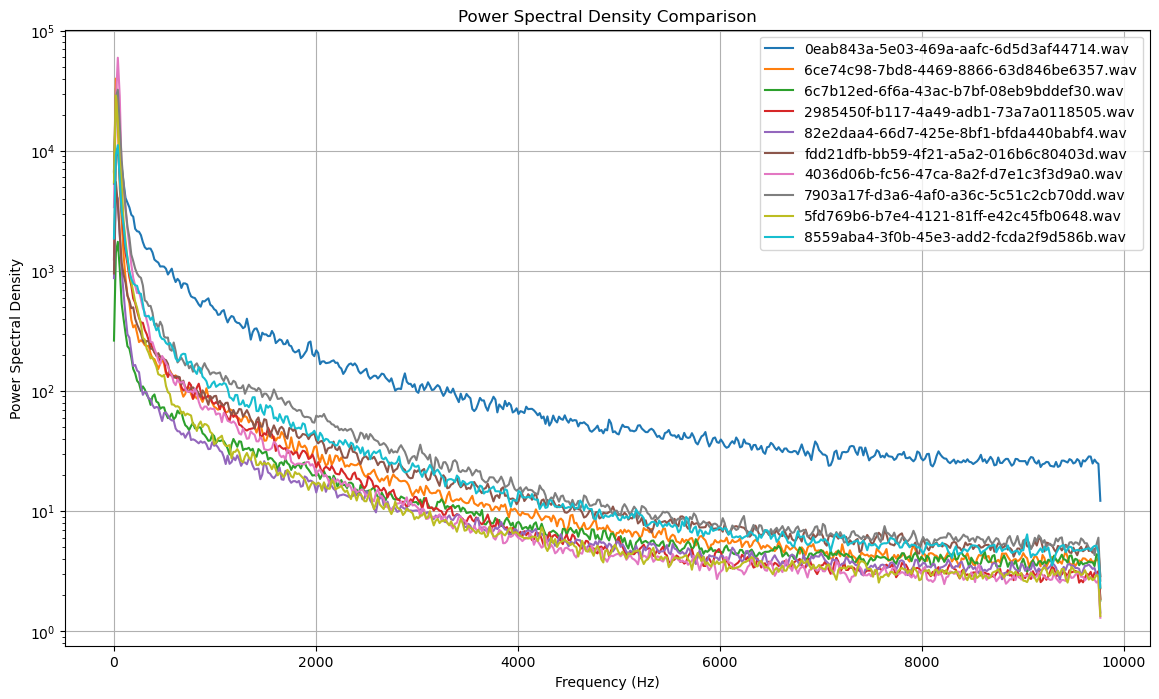

In [34]:
# Compare the PSD of multiple files
plt.figure(figsize=(14, 8))
for file in selected_files:
    with wave.open(os.path.join(data_dir, file), 'rb') as wav:
        sample_rate = wav.getframerate()
        wav_data = np.frombuffer(wav.readframes(wav.getnframes()), dtype=np.int16)
        frequencies, psd = signal.welch(wav_data, fs=sample_rate, nperseg=1024)
        plt.semilogy(frequencies, psd, label=file)

plt.title('Power Spectral Density Comparison')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power Spectral Density')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

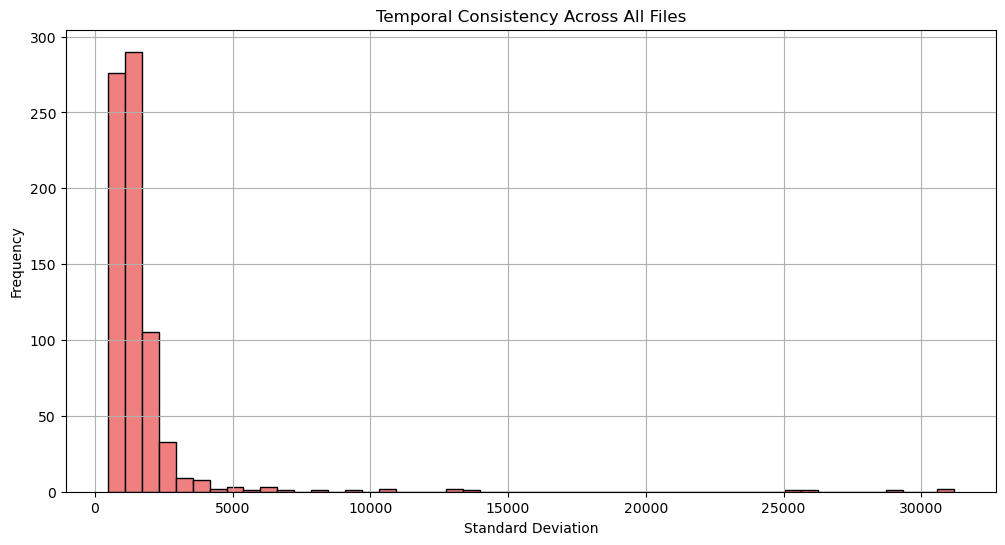

In [35]:
# Temporal consistency across all files
consistency_data = []
for file in wav_files:
    with wave.open(os.path.join(data_dir, file), 'rb') as wav:
        data = np.frombuffer(wav.readframes(wav.getnframes()), dtype=np.int16)
        consistency_data.append(np.std(data))

plt.figure(figsize=(12, 6))
plt.hist(consistency_data, bins=50, color='lightcoral', edgecolor='black')
plt.title('Temporal Consistency Across All Files')
plt.xlabel('Standard Deviation')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [40]:
# Temporal Consistency Check
print("\nTemporal Consistency:")
consistency_data = []
for file in wav_files:
    with wave.open(os.path.join(data_dir, file), 'rb') as wav:
        data = np.frombuffer(wav.readframes(wav.getnframes()), dtype=np.int16)
        consistency_data.append(np.std(data))

consistency_std_dev = np.std(consistency_data)
print(f"Standard Deviation Across Files: {consistency_std_dev}")


Temporal Consistency:
Standard Deviation Across Files: 2524.295651684043


**Standard Deviation Across Files:** 2524.295651684043

The relatively high standard deviation among file consistencies suggests variability in signal stability or quality between recordings. This could be due to differences in how the recordings were made or natural variations in the neural activity recorded.

**Implications**: The compression scheme might benefit from adaptive parameters that adjust based on the characteristics of each file, potentially enhancing both compression efficiency and fidelity.


In [41]:
# Ensuring data length consistency for correlation calculation
min_length = min([wave.open(os.path.join(data_dir, f), 'rb').getnframes() for f in selected_files])

correlation_matrix = np.zeros((10, 10))
for i, file1 in enumerate(selected_files):
    for j, file2 in enumerate(selected_files):
        with wave.open(os.path.join(data_dir, file1), 'rb') as wav1, wave.open(os.path.join(data_dir, file2), 'rb') as wav2:
            data1 = np.frombuffer(wav1.readframes(min_length), dtype=np.int16)
            data2 = np.frombuffer(wav2.readframes(min_length), dtype=np.int16)
            correlation_matrix[i, j] = np.corrcoef(data1, data2)[0, 1]

print("\nCorrelation Matrix:")
print(correlation_matrix)



Correlation Matrix:
[[ 1.00000000e+00  9.67863220e-03 -5.10878894e-02  4.75348854e-02
  -2.22815105e-02  1.07005768e-01 -3.29291882e-02  3.63134814e-02
  -6.67496980e-02 -3.03465247e-02]
 [ 9.67863220e-03  1.00000000e+00 -2.13358546e-02 -5.61726775e-02
  -7.04498913e-02 -4.93392097e-02  1.81366876e-02  1.57916681e-02
  -7.04024476e-03 -2.25814848e-02]
 [-5.10878894e-02 -2.13358546e-02  1.00000000e+00  5.30791119e-02
  -3.15553930e-02  9.45976990e-04 -1.18620892e-02  1.10741419e-02
   2.25908133e-03 -2.37708852e-02]
 [ 4.75348854e-02 -5.61726775e-02  5.30791119e-02  1.00000000e+00
   1.72774271e-02 -5.92400123e-02 -9.03817475e-02  8.37751329e-03
  -4.15650863e-02  4.60838095e-02]
 [-2.22815105e-02 -7.04498913e-02 -3.15553930e-02  1.72774271e-02
   1.00000000e+00  6.23595368e-02 -2.66546986e-02 -1.12345930e-02
   2.12410009e-02  3.67441402e-02]
 [ 1.07005768e-01 -4.93392097e-02  9.45976990e-04 -5.92400123e-02
   6.23595368e-02  1.00000000e+00 -2.38448435e-02  2.89552308e-02
  -3.0033696

**Low Correlations**: The correlations between different files are generally very low, indicating that there is little redundancy across different recordings. This lack of redundancy across files means that inter-file compression techniques (like those used in video compression to exploit similarities between frames) may not be effective.

**Implications**: Focus on intra-file compression techniques, such as exploiting within-file redundancies or patterns, which are more likely to yield effective compression ratios.



Spectral Entropy:
0eab843a-5e03-469a-aafc-6d5d3af44714.wav: 6.080822944641113
6ce74c98-7bd8-4469-8866-63d846be6357.wav: 3.431938648223877
6c7b12ed-6f6a-43ac-b7bf-08eb9bddef30.wav: 6.671555995941162
2985450f-b117-4a49-adb1-73a7a0118505.wav: 4.751796245574951
82e2daa4-66d7-425e-8bf1-bfda440babf4.wav: 5.204154968261719
fdd21dfb-bb59-4f21-a5a2-016b6c80403d.wav: 6.1355061531066895
4036d06b-fc56-47ca-8a2f-d7e1c3f3d9a0.wav: 3.172799825668335
7903a17f-d3a6-4af0-a36c-5c51c2cb70dd.wav: 4.280030250549316
5fd769b6-b7e4-4121-81ff-e42c45fb0648.wav: 3.5730559825897217
8559aba4-3f0b-45e3-add2-fcda2f9d586b.wav: 5.32900333404541


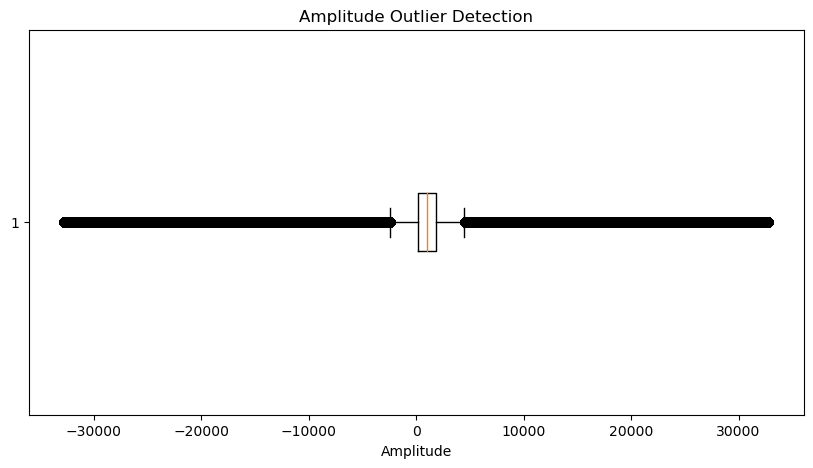

In [42]:
# Spectral Entropy Calculation
print("\nSpectral Entropy:")
for file in selected_files:
    with wave.open(os.path.join(data_dir, file), 'rb') as wav:
        data = np.frombuffer(wav.readframes(wav.getnframes()), dtype=np.int16)
        freqs, psd = signal.welch(data, fs=20000, nperseg=1024)
        psd_norm = psd / np.sum(psd)  # normalize the PSD
        spectral_entropy = -np.sum(psd_norm * np.log2(psd_norm))
        print(f"{file}: {spectral_entropy}")

# Exploratory Data Analysis (EDA) for Outlier Detection
plt.figure(figsize=(10, 5))
plt.boxplot(amplitude_values, vert=False)
plt.title('Amplitude Outlier Detection')
plt.xlabel('Amplitude')
plt.show()

**Variability in Spectral Entropy**:
The spectral entropy values vary across files, suggesting differences in the predictability and complexity of the frequency distributions from one recording to another.

**Implications**:
Files with lower spectral entropy (more predictable) may be more amenable to certain types of compression algorithms (like those using predictive coding). This suggests a potential for a hybrid approach where different algorithms are applied based on the spectral entropy of the data.


In [43]:
# Initialize variables to store information about the WAV files
sample_rates = []
num_channels = []
sample_widths = []
num_frames = []
durations = []

# Iterate over each WAV file and extract relevant information
for wav_file in wav_files:
    with wave.open(os.path.join(data_dir, wav_file), 'rb') as wav:
        sample_rates.append(wav.getframerate())
        num_channels.append(wav.getnchannels())
        sample_widths.append(wav.getsampwidth())
        num_frames.append(wav.getnframes())
        durations.append(wav.getnframes() / wav.getframerate())

# Print the unique sample rates, number of channels, and sample widths
print(f"Unique sample rates: {np.unique(sample_rates)}")
print(f"Unique number of channels: {np.unique(num_channels)}")
print(f"Unique sample widths: {np.unique(sample_widths)}")

# Print the minimum, maximum, and average number of frames and durations
print(f"Minimum number of frames: {np.min(num_frames)}")
print(f"Maximum number of frames: {np.max(num_frames)}")
print(f"Average number of frames: {np.mean(num_frames)}")
print(f"Minimum duration: {np.min(durations)} seconds")
print(f"Maximum duration: {np.max(durations)} seconds")
print(f"Average duration: {np.mean(durations)} seconds")

Unique sample rates: [19531]
Unique number of channels: [1]
Unique sample widths: [2]
Minimum number of frames: 98567
Maximum number of frames: 99903
Average number of frames: 98767.04845222073
Minimum duration: 5.046694997695971 seconds
Maximum duration: 5.115099073268138 seconds
Average duration: 5.056937609555105 seconds


**Consistent Sample Rates and Durations:** The consistency in sample rates and very similar durations across files is beneficial as it allows for uniform processing steps without needing to resample or interpolate data.

**Implications**: The uniformity in sampling rate and channel number allows for the standardization of the preprocessing steps, reducing the complexity of the compression pipeline.

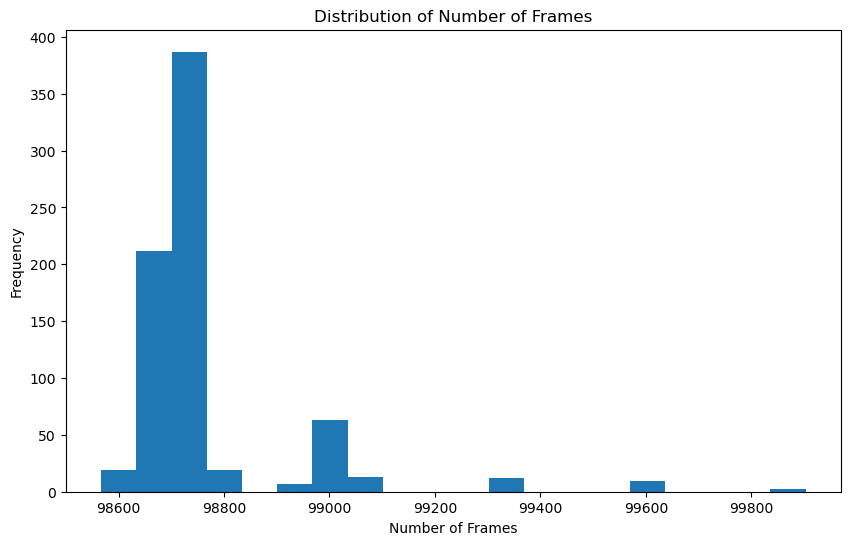

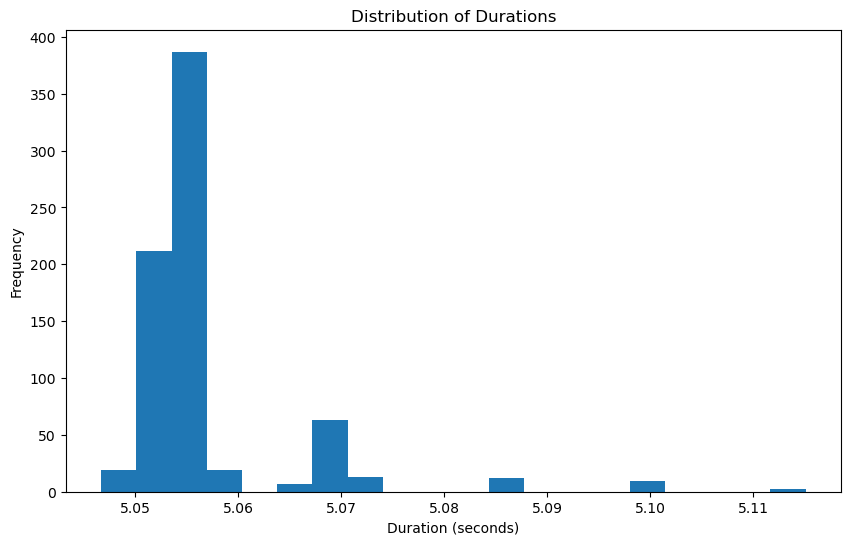

In [44]:
# Plot a histogram of the number of frames
plt.figure(figsize=(10, 6))
plt.hist(num_frames, bins=20)
plt.xlabel('Number of Frames')
plt.ylabel('Frequency')
plt.title('Distribution of Number of Frames')
plt.show()

# Plot a histogram of the durations
plt.figure(figsize=(10, 6))
plt.hist(durations, bins=20)
plt.xlabel('Duration (seconds)')
plt.ylabel('Frequency')
plt.title('Distribution of Durations')
plt.show()

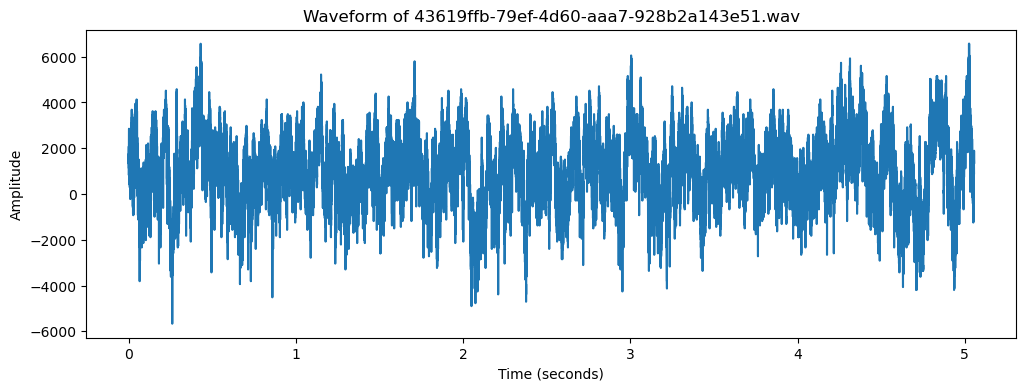

In [45]:
# Read a random WAV file and plot its waveform
random_wav_file = np.random.choice(wav_files)
with wave.open(os.path.join(data_dir, random_wav_file), 'rb') as wav:
    sample_rate = wav.getframerate()
    num_frames = wav.getnframes()
    wav_data = wav.readframes(num_frames)
    wav_data = np.frombuffer(wav_data, dtype=np.int16)

time = np.linspace(0, len(wav_data) / sample_rate, num=len(wav_data))

plt.figure(figsize=(12, 4))
plt.plot(time, wav_data)
plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude')
plt.title(f'Waveform of {random_wav_file}')
plt.show()

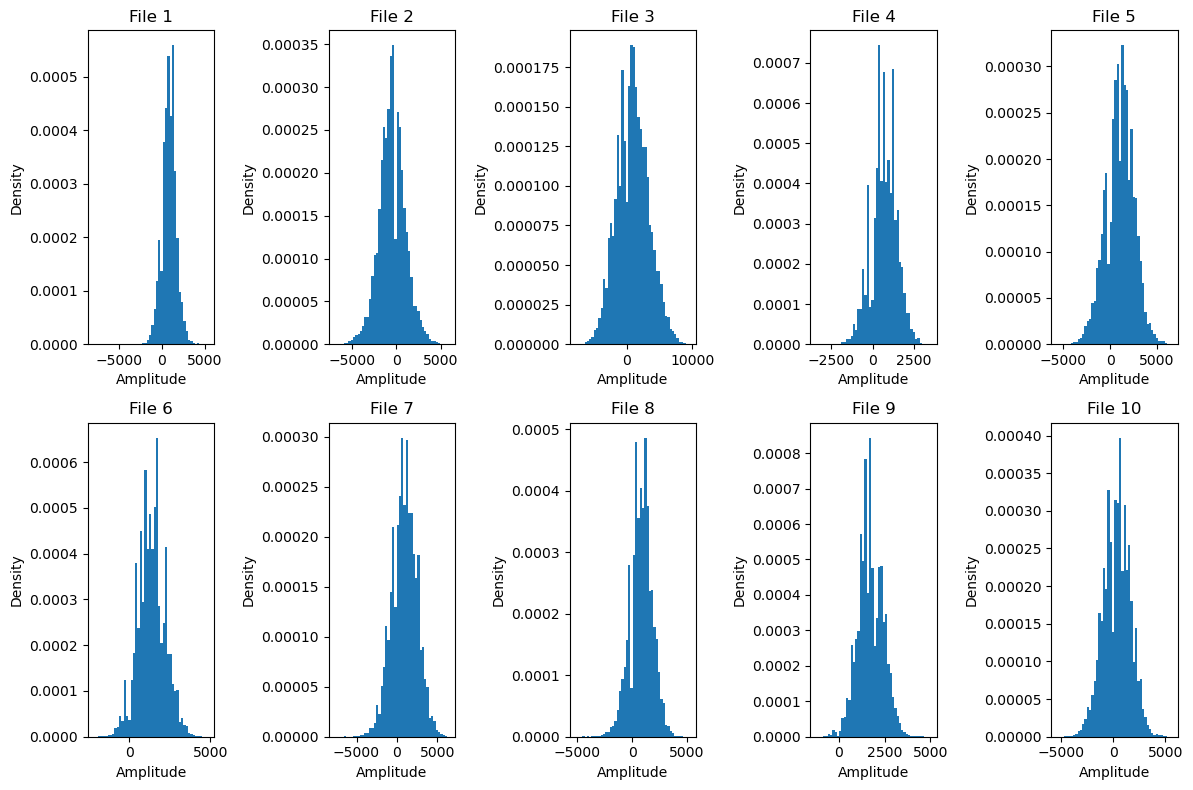

In [46]:
# Randomly select a subset of WAV files (e.g., 10 files)
num_files = 10
random_files = np.random.choice(wav_files, size=num_files, replace=False)

# Initialize a list to store the amplitude distributions
amplitude_distributions = []

# Iterate over the randomly selected files
for wav_file in random_files:
    with wave.open(os.path.join(data_dir, wav_file), 'rb') as wav:
        wav_data = wav.readframes(wav.getnframes())
        wav_data = np.frombuffer(wav_data, dtype=np.int16)
        amplitude_distributions.append(wav_data)

# Plot the amplitude distributions
plt.figure(figsize=(12, 8))
for i, dist in enumerate(amplitude_distributions):
    plt.subplot(2, 5, i+1)
    plt.hist(dist, bins=50, density=True)
    plt.xlabel('Amplitude')
    plt.ylabel('Density')
    plt.title(f'File {i+1}')
plt.tight_layout()
plt.show()

**Variability in Amplitude Distributions**
The differing ranges and shapes of amplitude distributions across randomly selected files suggest variability in the signal amplitude and possibly the state of the neural activity or external noise factors.

**Implications**: Adaptive compression algorithms that can adjust to the amplitude characteristics of each file might be more effective than a one-size-fits-all approach.


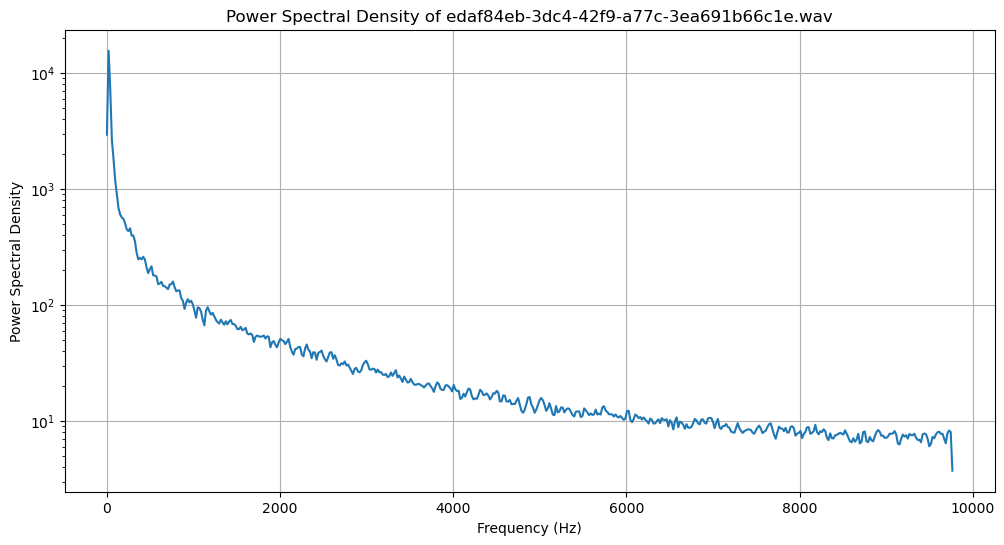

In [47]:
from scipy import signal

# Randomly select a WAV file
random_wav_file = np.random.choice(wav_files)

# Read the WAV file
with wave.open(os.path.join(data_dir, random_wav_file), 'rb') as wav:
    sample_rate = wav.getframerate()
    wav_data = wav.readframes(wav.getnframes())
    wav_data = np.frombuffer(wav_data, dtype=np.int16)

# Compute the power spectral density (PSD)
frequencies, psd = signal.welch(wav_data, fs=sample_rate, nperseg=1024)

# Plot the power spectral density
plt.figure(figsize=(12, 6))
plt.semilogy(frequencies, psd)
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power Spectral Density')
plt.title(f'Power Spectral Density of {random_wav_file}')
plt.grid(True)
plt.show()

**Exponential Decrease in PSD**: The typical exponential decay of the PSD indicates most of the energy is concentrated at lower frequencies, a common characteristic in physiological signals. Higher frequencies contain less information and might be artifacts or noise.

**Implications**: This suggests potential for frequency-based compression techniques, such as subband coding or wavelet transform methods, which could focus on preserving the information-rich lower frequencies while compressing or even discarding the higher-frequency content more aggressively.


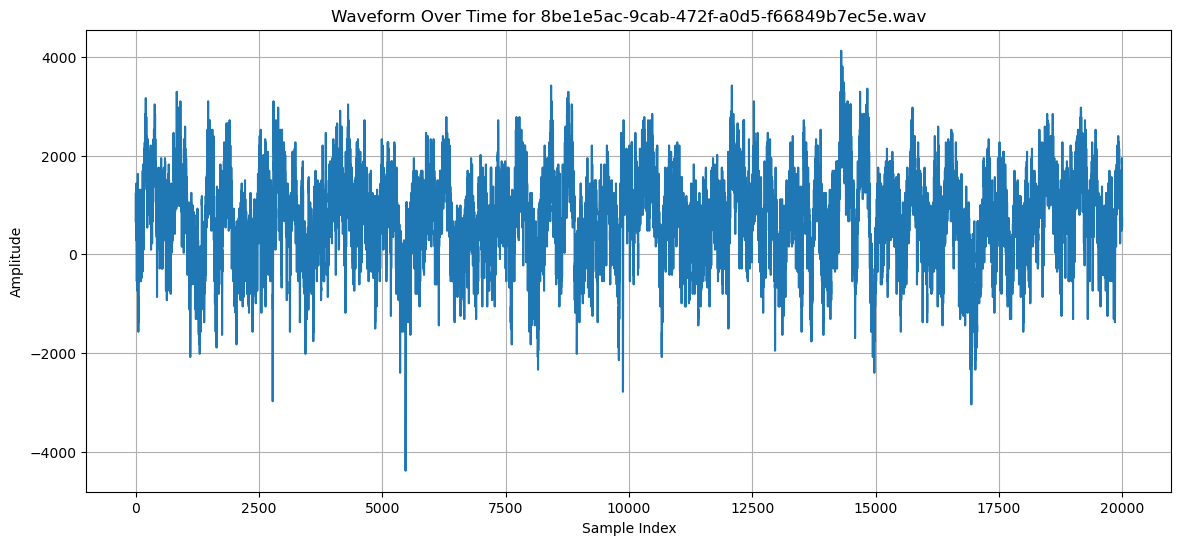

In [48]:
# Example for a single file
wav_file = np.random.choice(wav_files)
signal_data = np.frombuffer(wave.open(os.path.join(data_dir, wav_file), 'rb').readframes(-1), dtype=np.int16)

plt.figure(figsize=(14, 6))
plt.plot(signal_data[:20000])  # Plotting first part of one file
plt.title(f'Waveform Over Time for {wav_file}')
plt.xlabel('Sample Index')
plt.ylabel('Amplitude')
plt.grid(True)
plt.show()


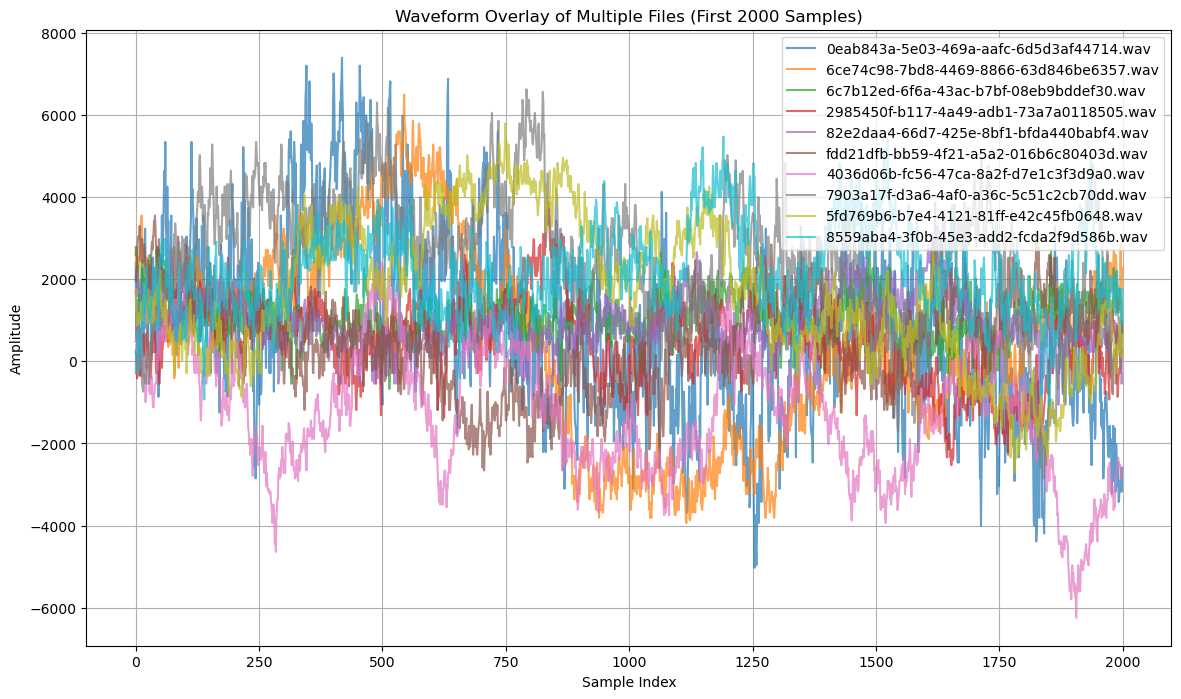

In [36]:
# Overlay waveforms of multiple files
plt.figure(figsize=(14, 8))
for file in selected_files:
    with wave.open(os.path.join(data_dir, file), 'rb') as wav:
        wav_data = np.frombuffer(wav.readframes(wav.getnframes()), dtype=np.int16)
        plt.plot(wav_data[:2000], alpha=0.7, label=file)

plt.title('Waveform Overlay of Multiple Files (First 2000 Samples)')
plt.xlabel('Sample Index')
plt.ylabel('Amplitude')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

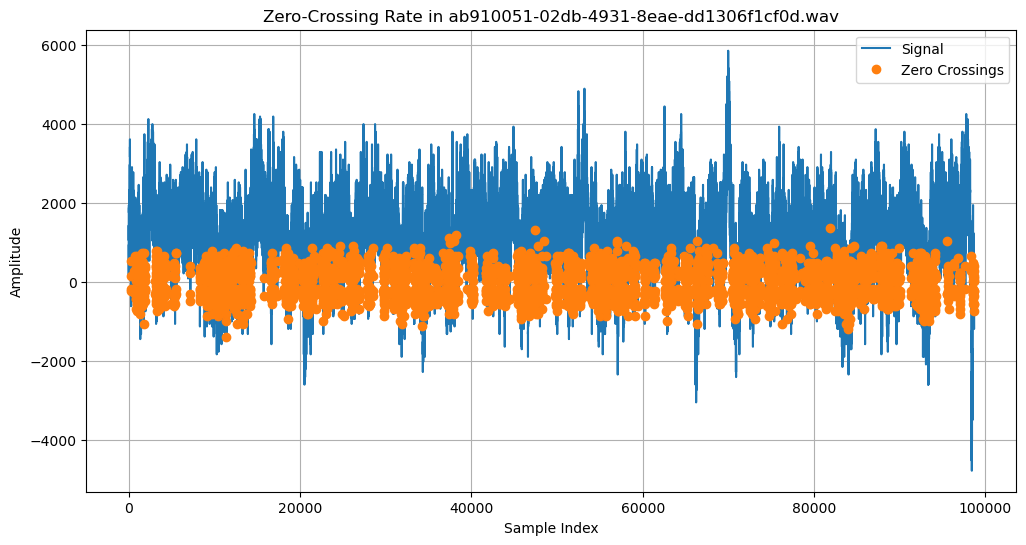

In [39]:
# Zero-crossing rate of a random WAV file
random_wav_file = np.random.choice(wav_files)
with wave.open(os.path.join(data_dir, random_wav_file), 'rb') as wav:
    wav_data = np.frombuffer(wav.readframes(wav.getnframes()), dtype=np.int16)

zero_crossings = np.where(np.diff(np.sign(wav_data)))[0]

plt.figure(figsize=(12, 6))
plt.plot(wav_data, label='Signal')
plt.plot(zero_crossings, wav_data[zero_crossings], 'o', label='Zero Crossings')
plt.title(f'Zero-Crossing Rate in {random_wav_file}')
plt.xlabel('Sample Index')
plt.ylabel('Amplitude')
plt.legend()
plt.grid(True)
plt.show()

In [54]:
!pip install pywavelets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.3/4.3 MB 25.9 MB/s eta 0:00:00a 0:00:01


# IWT ANALYSIS:


Entropy of original data: 6.61722872267744
Entropy of transformed data: 12.865054595700107


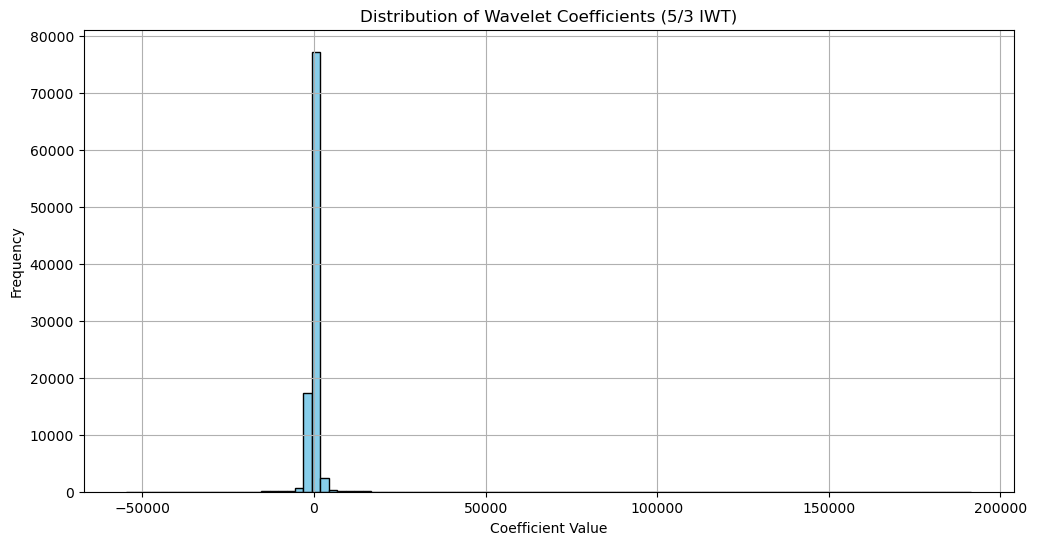

In [55]:
import pywt

# Function to perform the 5/3 Integer Wavelet Transform
def iiwt53(data):
    coeffs = pywt.wavedec(data, 'bior1.5', mode='periodization')
    return coeffs

# Function to calculate entropy
def calculate_entropy(data):
    value, counts = np.unique(data, return_counts=True)
    probs = counts / len(data)
    entropy = -np.sum(probs * np.log2(probs))
    return entropy

# Select a random WAV file and perform the IWT
random_wav_file = np.random.choice(wav_files)
with wave.open(os.path.join(data_dir, random_wav_file), 'rb') as wav:
    wav_data = np.frombuffer(wav.readframes(wav.getnframes()), dtype=np.int16)

# Perform the 5/3 Integer Wavelet Transform
coeffs = iiwt53(wav_data)

# Flatten the coefficients for analysis
flattened_coeffs = np.hstack(coeffs)

# Calculate and print the entropy of the original and transformed data
original_entropy = calculate_entropy(wav_data)
transformed_entropy = calculate_entropy(flattened_coeffs)

print(f"Entropy of original data: {original_entropy}")
print(f"Entropy of transformed data: {transformed_entropy}")

# Plot the distribution of the wavelet coefficients
plt.figure(figsize=(12, 6))
plt.hist(flattened_coeffs, bins=100, color='skyblue', edgecolor='black')
plt.title('Distribution of Wavelet Coefficients (5/3 IWT)')
plt.xlabel('Coefficient Value')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

Entropy of Haar transformed data: 11.421944364511772
Entropy of LeGall 5/3 transformed data: 13.851163214047203


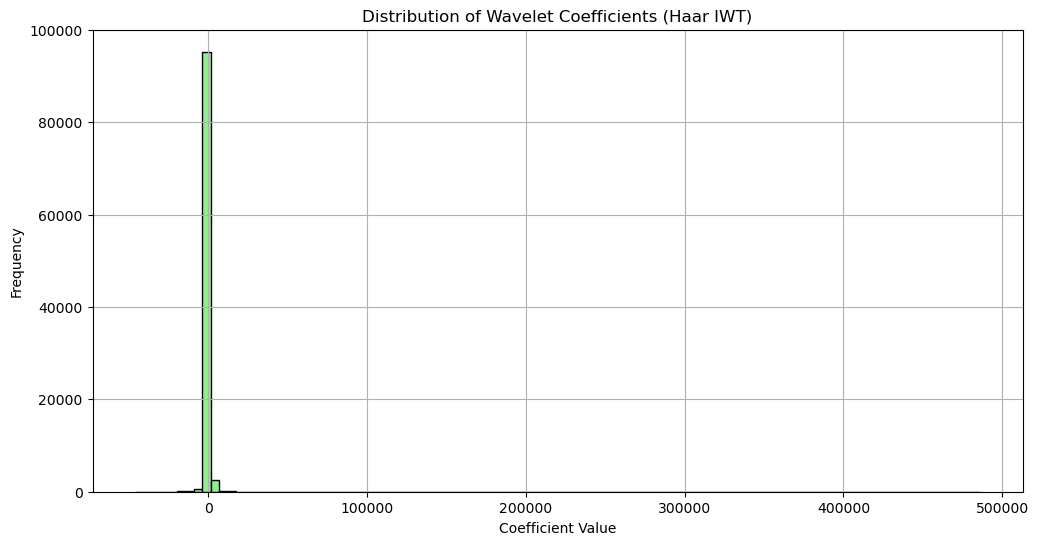

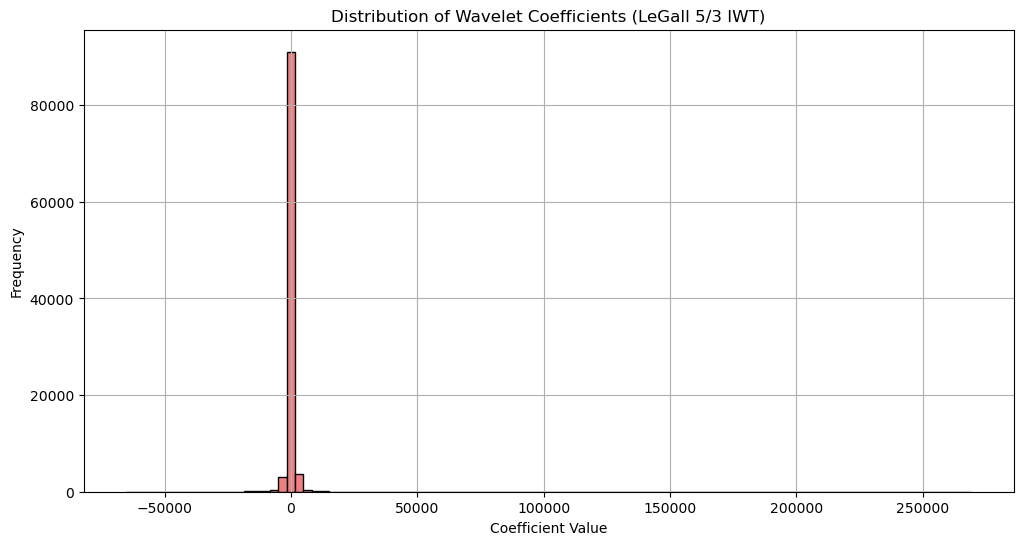

In [56]:
# Function to perform the Haar Integer Wavelet Transform
def iiwt_haar(data):
    coeffs = pywt.wavedec(data, 'haar', mode='periodization')
    return coeffs

# Function to perform the LeGall 5/3 Integer Wavelet Transform
def iiwt_lg53(data):
    coeffs = pywt.wavedec(data, 'bior2.2', mode='periodization')
    return coeffs

# Perform the Haar Integer Wavelet Transform
coeffs_haar = iiwt_haar(wav_data)
flattened_coeffs_haar = np.hstack(coeffs_haar)
transformed_entropy_haar = calculate_entropy(flattened_coeffs_haar)

# Perform the LeGall 5/3 Integer Wavelet Transform
coeffs_lg53 = iiwt_lg53(wav_data)
flattened_coeffs_lg53 = np.hstack(coeffs_lg53)
transformed_entropy_lg53 = calculate_entropy(flattened_coeffs_lg53)

print(f"Entropy of Haar transformed data: {transformed_entropy_haar}")
print(f"Entropy of LeGall 5/3 transformed data: {transformed_entropy_lg53}")

# Plot the distribution of the Haar wavelet coefficients
plt.figure(figsize=(12, 6))
plt.hist(flattened_coeffs_haar, bins=100, color='lightgreen', edgecolor='black')
plt.title('Distribution of Wavelet Coefficients (Haar IWT)')
plt.xlabel('Coefficient Value')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# Plot the distribution of the LeGall 5/3 wavelet coefficients
plt.figure(figsize=(12, 6))
plt.hist(flattened_coeffs_lg53, bins=100, color='lightcoral', edgecolor='black')
plt.title('Distribution of Wavelet Coefficients (LeGall 5/3 IWT)')
plt.xlabel('Coefficient Value')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [67]:
!pip install zstandard


In [70]:
import zstandard as zstd
import numpy as np
import wave
import os

# Function to compress data using Zstd
def compress_data(data):
    cctx = zstd.ZstdCompressor()
    compressed = cctx.compress(data)
    return compressed

# Assuming 'wav_files' is a list of file paths and 'data_dir' is the directory containing these files
total_size_raw = 0
total_size_compressed = 0

for wav_file in wav_files:
    with wave.open(os.path.join(data_dir, wav_file), 'rb') as wav:
        wav_data = np.frombuffer(wav.readframes(wav.getnframes()), dtype=np.int16)
        file_size = len(wav_data.tobytes())
        total_size_raw += file_size

        # Compress the original data
        compressed_data = compress_data(wav_data.tobytes())
        compressed_size = len(compressed_data)
        total_size_compressed += compressed_size

        print(f"{wav_file} losslessly compressed from {file_size} bytes to {compressed_size} bytes")

# Calculate the compression ratio
compression_ratio = total_size_raw / total_size_compressed if total_size_compressed != 0 else 0

print(f"Original total size (bytes): {total_size_raw}")
print(f"Compressed total size (bytes): {total_size_compressed}")
print(f"Compression ratio: {compression_ratio:.2f}")

102b47d9-371e-412a-8995-0dc6115ab2bb.wav losslessly compressed from 197398 bytes to 91033 bytes
2eef5d4d-93d1-4c0e-9d23-0989abaa34d0.wav losslessly compressed from 197442 bytes to 92791 bytes
fa2c5efb-cc0d-4292-ab99-91d345cf17d9.wav losslessly compressed from 198620 bytes to 112747 bytes
0458e9fc-6403-427e-afec-6a659104399a.wav losslessly compressed from 197418 bytes to 82406 bytes
30dee5fe-ded7-4978-9480-e40155e7b060.wav losslessly compressed from 197284 bytes to 97852 bytes
3953a230-d130-40e9-9dc4-068dda9bcef1.wav losslessly compressed from 197428 bytes to 77446 bytes
760ba446-aae7-4136-922c-9351c97504b8.wav losslessly compressed from 197452 bytes to 93731 bytes
2b1627e1-85a5-4155-ba52-4400e036b034.wav losslessly compressed from 197448 bytes to 93246 bytes
8559aba4-3f0b-45e3-add2-fcda2f9d586b.wav losslessly compressed from 198676 bytes to 91699 bytes
4036d06b-fc56-47ca-8a2f-d7e1c3f3d9a0.wav losslessly compressed from 197582 bytes to 90984 bytes
43758ea3-e5d2-4636-ad9c-ff5bfaa2914a.wa

In [71]:
import zstandard as zstd
import numpy as np
import wave
import os

# Function to decompress data using Zstd
def decompress_data(compressed_data):
    dctx = zstd.ZstdDecompressor()
    decompressed = dctx.decompress(compressed_data)
    return decompressed

# Assuming 'wav_files' is a list of file paths and 'data_dir' is the directory containing these files
for wav_file in wav_files:
    with wave.open(os.path.join(data_dir, wav_file), 'rb') as wav:
        original_data = wav.readframes(wav.getnframes())
        original_data_bytes = np.frombuffer(original_data, dtype=np.int16).tobytes()

        # Compress the data
        compressed_data = compress_data(original_data_bytes)

        # Decompress the data
        decompressed_data_bytes = decompress_data(compressed_data)

        # Verify losslessness
        if original_data_bytes == decompressed_data_bytes:
            print(f"{wav_file}: Losslessly decompressed.")
        else:
            print(f"ERROR: {wav_file} did not decompress losslessly.")
            break

102b47d9-371e-412a-8995-0dc6115ab2bb.wav: Losslessly decompressed.
2eef5d4d-93d1-4c0e-9d23-0989abaa34d0.wav: Losslessly decompressed.
fa2c5efb-cc0d-4292-ab99-91d345cf17d9.wav: Losslessly decompressed.
0458e9fc-6403-427e-afec-6a659104399a.wav: Losslessly decompressed.
30dee5fe-ded7-4978-9480-e40155e7b060.wav: Losslessly decompressed.
3953a230-d130-40e9-9dc4-068dda9bcef1.wav: Losslessly decompressed.
760ba446-aae7-4136-922c-9351c97504b8.wav: Losslessly decompressed.
2b1627e1-85a5-4155-ba52-4400e036b034.wav: Losslessly decompressed.
8559aba4-3f0b-45e3-add2-fcda2f9d586b.wav: Losslessly decompressed.
4036d06b-fc56-47ca-8a2f-d7e1c3f3d9a0.wav: Losslessly decompressed.
43758ea3-e5d2-4636-ad9c-ff5bfaa2914a.wav: Losslessly decompressed.
9397fd43-e0df-4c75-b27e-04c3ed2f0fb8.wav: Losslessly decompressed.
741e1978-11fb-4f4a-bf25-c43c239c226c.wav: Losslessly decompressed.
fea48b69-ccde-439e-9e7c-f06c72832c52.wav: Losslessly decompressed.
bc9115d8-2363-4159-ae41-295a9129a9aa.wav: Losslessly decompres

In [69]:
import zstandard as zstd
import numpy as np
import wave
import os
import pywt

# Function to compress data using Zstd
def compress_data(data):
    cctx = zstd.ZstdCompressor()
    compressed = cctx.compress(data)
    return compressed

# Function to perform the Haar Integer Wavelet Transform
def iiwt_haar(data):
    coeffs = pywt.wavedec(data, 'haar', mode='periodization')
    flattened_coeffs = np.hstack(coeffs)
    return flattened_coeffs

# Assuming 'wav_files' is a list of file paths and 'data_dir' is the directory containing these files
total_size_raw = 0
total_size_compressed = 0

for wav_file in wav_files:
    with wave.open(os.path.join(data_dir, wav_file), 'rb') as wav:
        wav_data = np.frombuffer(wav.readframes(wav.getnframes()), dtype=np.int16)
        file_size = len(wav_data.tobytes())
        total_size_raw += file_size

        # Perform Haar wavelet transform
        transformed_data = iiwt_haar(wav_data)

        # Compress the Haar transformed data
        compressed_data = compress_data(transformed_data.tobytes())
        compressed_size = len(compressed_data)
        total_size_compressed += compressed_size

        print(f"{wav_file} Haar transformed and compressed from {file_size} bytes to {compressed_size} bytes")

# Calculate the compression ratio
compression_ratio = total_size_raw / total_size_compressed if total_size_compressed != 0 else 0

print(f"Original total size (bytes): {total_size_raw}")
print(f"Compressed total size (bytes): {total_size_compressed}")
print(f"Compression ratio: {compression_ratio:.2f}")

102b47d9-371e-412a-8995-0dc6115ab2bb.wav Haar transformed and compressed from 197398 bytes to 235741 bytes
2eef5d4d-93d1-4c0e-9d23-0989abaa34d0.wav Haar transformed and compressed from 197442 bytes to 238730 bytes
fa2c5efb-cc0d-4292-ab99-91d345cf17d9.wav Haar transformed and compressed from 198620 bytes to 239368 bytes
0458e9fc-6403-427e-afec-6a659104399a.wav Haar transformed and compressed from 197418 bytes to 226903 bytes
30dee5fe-ded7-4978-9480-e40155e7b060.wav Haar transformed and compressed from 197284 bytes to 240605 bytes
3953a230-d130-40e9-9dc4-068dda9bcef1.wav Haar transformed and compressed from 197428 bytes to 218466 bytes
760ba446-aae7-4136-922c-9351c97504b8.wav Haar transformed and compressed from 197452 bytes to 235455 bytes
2b1627e1-85a5-4155-ba52-4400e036b034.wav Haar transformed and compressed from 197448 bytes to 240411 bytes
8559aba4-3f0b-45e3-add2-fcda2f9d586b.wav Haar transformed and compressed from 198676 bytes to 235921 bytes
4036d06b-fc56-47ca-8a2f-d7e1c3f3d9a0.

In [72]:
import numpy as np
import wave
import os
from scipy.io import wavfile
from collections import Counter
import json

# Include the HuffmanNode, apply_delta_encoding, build_huffman_tree, generate_huffman_codes,
# create_canonical_huffman_code, compress_data_canonical, serialize_huffman_tree functions here

def compress_wav_files(wav_files, data_dir, output_dir):
    total_size_raw = 0
    total_size_compressed = 0

    for wav_file in wav_files:
        input_path = os.path.join(data_dir, wav_file)
        output_path = os.path.join(output_dir, wav_file + ".compressed")
        tree_path = os.path.join(output_dir, wav_file + "_tree.json")

        sample_rate, signal = wavfile.read(input_path)
        file_size = len(signal.tobytes())
        total_size_raw += file_size

        delta_encoded_signal = apply_delta_encoding(signal)
        symbol_freqs = Counter(delta_encoded_signal)
        huffman_tree = build_huffman_tree(symbol_freqs)
        symbol_codes = generate_huffman_codes(huffman_tree)
        canonical_codes = create_canonical_huffman_code(symbol_codes)
        encoded_bytes, padding = compress_data_canonical(delta_encoded_signal, canonical_codes)
        serialized_tree = serialize_huffman_tree(canonical_codes)

        with open(tree_path, 'w') as file:
            file.write(serialized_tree)

        sample_rate_bytes = sample_rate.to_bytes(4, byteorder='big')
        original_length_bytes = len(signal).to_bytes(4, byteorder='big')
        first_sample_bytes = int(signal[0]).to_bytes(2, byteorder='big', signed=True)
        compressed_data_with_metadata = sample_rate_bytes + original_length_bytes + first_sample_bytes + encoded_bytes

        with open(output_path, 'wb') as file:
            file.write(compressed_data_with_metadata)

        compressed_size = len(compressed_data_with_metadata)
        total_size_compressed += compressed_size

    compression_ratio = total_size_raw / total_size_compressed if total_size_compressed != 0 else 0
    return compression_ratio, total_size_raw, total_size_compressed

compression_ratio, total_size_raw, total_size_compressed = compress_wav_files(wav_files, data_dir, output_dir)
print(f"Original total size (bytes): {total_size_raw}")
print(f"Compressed total size (bytes): {total_size_compressed}")
print(f"Compression ratio: {compression_ratio:.2f}")

NameError: name 'output_dir' is not defined